In [1]:
import numpy as np
import pandas as pd
import imp
import os

import data
import util

imp.reload(data)
imp.reload(util)

<module 'util' from 'C:\\Users\\graham\\classes\\ds_exp\\ds-project\\src\\util.py'>

In [2]:
from IPython.display import Audio, display

url_exception = "http://www.wav-sounds.com/movie/austinpowers.wav"
url_exception = "https://www.myinstants.com/media/sounds/roblox-death-sound_1.mp3"


def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio(url=url_exception, autoplay=True))


get_ipython().set_custom_exc((Exception,), play_sound)

In [3]:
data_dir = os.path.join(os.getcwd(), "..", "data")
save_file = os.path.join(data_dir, "mega_stop_event.hdf")
df = pd.read_hdf(save_file, "/df", stop=10000)

In [4]:
df = df.sort_values(["service_date", "train", "stop_time"])

In [5]:
# print(sorted(df))
# print(df.dtypes.T)
# util.big_print(df.head(10))

In [6]:
# filter
df = df[
    [
        #         "apc_status",
        "arrival_deviance",
        "arrive_deviance_departure_delta",
        "arrive_time",
        "data_source",
        "day_of_week",
        "day_of_year",
        "direction",
        "door",
        "dwell",
        "estimated_load",
        "leave_time",
        "lift",
        "location_id",
        "maximum_speed",
        "offs",
        "ons",
        "pattern_distance",
        "route_number",
        "schedule_status",
        #         "service_date",
        "service_key",
        "stop_time",
        "time_cat_arrive_time",
        "time_cat_leave_time",
        "time_cat_stop_time",
        "train",
        "train_mileage",
        "trip_number",
        "vehicle_number",
        "x_coordinate",
        "y_coordinate",
    ]
]

In [7]:
df["label"] = df.groupby("trip_number")["arrival_deviance"].shift(-1)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

## how do we really want to structure this data?

* we want to make things somehow discrete by their trip_id
* so we want to somehow take the trip id and feed the model things about the trip
* we would feed it about the trip (up to different levels, and also expect it to answer about the whole trip each time
* yes so make a multi output thing that takes in a variable amount of information about the trip and answers about either - what it hasnt been supplied yet
* we want to have it somehow take in the previous x stops, and predict the next x stops?
* we dont want to punish it for guessing outside of the trip either
* we could also have it take in the last data to predict the stops
* start with only feeding it nothing besides day of the week and stuff, have it predict the times on the route
* slowly add in the realtime stats as the bus goes through its route, feeding it more each time
* we could either have it feed in more and more until it's filled, or just use a 0 padded window of bus stops. 
* let's look more into how rnn's and lstm's are normally constructed.


In [8]:
df = pd.get_dummies(df)  # turns all categoricals into one hot encoded columns!

In [9]:
df = df.astype("float32")

In [10]:
print("number of input features: ", len(sorted(df)))

number of input features:  1544


In [11]:
def train_val_test(train, val, test, df, target):
    assert train + val + test == 1
    data_len = len(df)
    train_size = int(train * data_len)
    val_size = int(val * data_len)

    x = []
    x.append(df.iloc[:train_size])
    x.append(df.iloc[train_size : train_size + val_size])
    x.append(df.iloc[train_size + val_size :])

    y = []
    for df in x:
        y.append(df.pop(target))

    return (*x, *y)


x_train, x_val, x_test, y_train, y_val, y_test = train_val_test(
    0.8, 0.1, 0.1, df, "label"
)

In [12]:
# shuffle
from numpy.random import default_rng


def shuffle_dfs(a, b):
    assert a.shape[0] == b.shape[0]
    length = a.shape[0]
    x = a
    y = b
    rng = default_rng()
    idx = rng.choice(length, length)
    x = x.iloc[idx]
    y = y.iloc[idx]
    return x, y


# x_train, y_train = shuffle_dfs(x_train, y_train)

In [13]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import Pipeline

# pipe = Pipeline([("scaler", MinMaxScaler()), ("pca", PCA(300))])
# x_train = pipe.fit_transform(x_train)
# print("sum of variance_ratio: ", np.sum(pipe["pca"].explained_variance_ratio_))
# x_val = pipe.transform(x_val)
# x_test = pipe.transform(x_test)

In [14]:
import tensorflow as tf

tf.random.set_seed(1234)

In [15]:
def get_compiled_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1000, activation="relu"),
            tf.keras.layers.Dense(500, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu"),
            #             tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.MeanSquaredError(
            reduction="auto", name="mean_squared_error"
        ),
        metrics=["accuracy", "mean_absolute_error"],
    )

    return model

In [16]:
model = get_compiled_model()
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error", patience=2, restore_best_weights=True
)
model.fit(
    x=x_train,
    y=y_train,
    batch_size=50,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[callback],
)

Epoch 1/100
1599/1599 [==============================] - 15s 9ms/step - loss: 700018.0000 - accuracy: 0.0034 - mean_absolute_error: 126.9842 - val_loss: 1331859.8750 - val_accuracy: 0.0041 - val_mean_absolute_error: 381.3351
Epoch 2/100
1599/1599 [==============================] - 13s 8ms/step - loss: 694331.7500 - accuracy: 0.0036 - mean_absolute_error: 127.6876 - val_loss: 8558156.0000 - val_accuracy: 0.0041 - val_mean_absolute_error: 1793.0892
Epoch 3/100
1599/1599 [==============================] - 14s 9ms/step - loss: 693642.3750 - accuracy: 0.0036 - mean_absolute_error: 134.3877 - val_loss: 5129158.5000 - val_accuracy: 0.0038 - val_mean_absolute_error: 1312.7069


In [17]:
model.evaluate(x=x_test, y=y_test)

313/313 [==============================] - 1s 3ms/step - loss: 683297.0625 - accuracy: 0.0053 - mean_absolute_error: 481.5450


[683297.0625, 0.005304243415594101, 481.5450439453125]

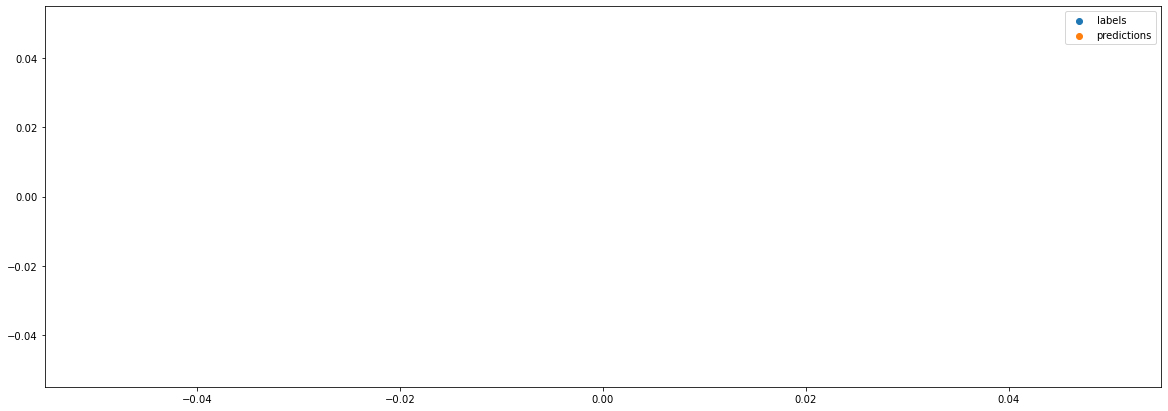

In [18]:
preds = model.predict(x=x_test)
util.plot(69, 420, preds, y_test)
util.allDone()